# Classificador de AVCS

Imports de bibliotecas que serão utilizadas para criar o programa.

In [73]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

Parte 1 - Treinar um classificador para predizer se houve ou não houve AVCs

O primeiro passo do programa é preparar os dados para a análise. O csv é carregado e as linhas com valores nulos são eliminadas, para que não atrapalhem na análise dos dados. As colunas age, bmi e avg_glucose_level contêm dados categóricos que precisam ser categorizados antes da análise, então foram criadas novas colunas no dataset ("age_group", "bmi_group" e "glucose_level_group") e utilizado o df.loc[] para atribuir os valores às novas categorias. Posteriormente, as colunas id, age, bmi e avg_glucose_level são eliminadas, pois as três últimas já tiveram seus dados transferidos e categorizados e a primeira não será utilizada na análise. Por último, utiliza-se "df.head()" para apresentar como o novo dataframe ficou.

In [74]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv', sep=',')
df = df.dropna()

df['age_group'] = ''
df.loc[(df['age'] <= 10), 'age_group'] = 'Children'
df.loc[(df['age'] > 10) & (df['age'] <= 20), 'age_group'] = 'Teenager'
df.loc[(df['age'] > 20) & (df['age'] <= 65), 'age_group'] = 'Adult'
df.loc[(df['age'] > 65), 'age_group'] = 'Elderly'

df['bmi_group'] = ''
df.loc[(df['bmi'] <= 18.5), 'bmi_group'] = 'Underweight'
df.loc[(df['bmi'] > 18.5) & (df['bmi'] <= 24.9), 'bmi_group'] = 'Normal'
df.loc[(df['bmi'] > 24.9) & (df['bmi'] <= 29.9), 'bmi_group'] = 'Overweight'
df.loc[(df['bmi'] > 29.9), 'bmi_group'] = 'Obese'

df['glucose_level_group'] = ''
df.loc[(df['avg_glucose_level'] <= 140), 'glucose_level_group'] = 'Normal'
df.loc[(df['avg_glucose_level'] > 140) & (df['avg_glucose_level'] <= 200), 'glucose_level_group'] = 'Prediabetes'
df.loc[(df['avg_glucose_level'] > 200), 'glucose_level_group'] = 'Diabetes'

df.drop(columns=['age', 'bmi', 'avg_glucose_level', 'id'], inplace=True)

df.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,age_group,bmi_group,glucose_level_group
0,Male,0,1,Yes,Private,Urban,formerly smoked,1,Elderly,Obese,Diabetes
2,Male,0,1,Yes,Private,Rural,never smoked,1,Elderly,Obese,Normal
3,Female,0,0,Yes,Private,Urban,smokes,1,Adult,Obese,Prediabetes
4,Female,1,0,Yes,Self-employed,Rural,never smoked,1,Elderly,Normal,Prediabetes
5,Male,0,0,Yes,Private,Urban,formerly smoked,1,Elderly,Overweight,Prediabetes


Aqui são separados os dados de entrada (features) e saída (outcomes). Isso é feito para conseguir prever o resultado através dos fatores. Em seguida, é aplicada uma conversão one-hot-encoding através da função get_dummies para converter os dados categóricos em dados numéricos.

In [75]:
df_entrada = df.drop(['stroke'], axis=1)
df_saida = df['stroke']

df_entrada = pd.get_dummies(df_entrada)

Aqui os dados de treino e de teste são separados. O conjunto de treino vai ser utilizado para treinar os classificadores, e o de teste para simular uma situação de produção, o que é feito através da função train_test_split. Em seguida é criada uma árvore de decisão através do DecisionTreeClassifier, que faz previsões e toma decisões a partir dos dados de treino, com critério de entropia utilizado para otimizar suas possibilidades. A terminação .fit se refere ao treino do conjunto de treino e a .score a testar os classificadores. Em seguida, a árvore de decisão é plotada na tela, para se ter noção de como o programa está operando.

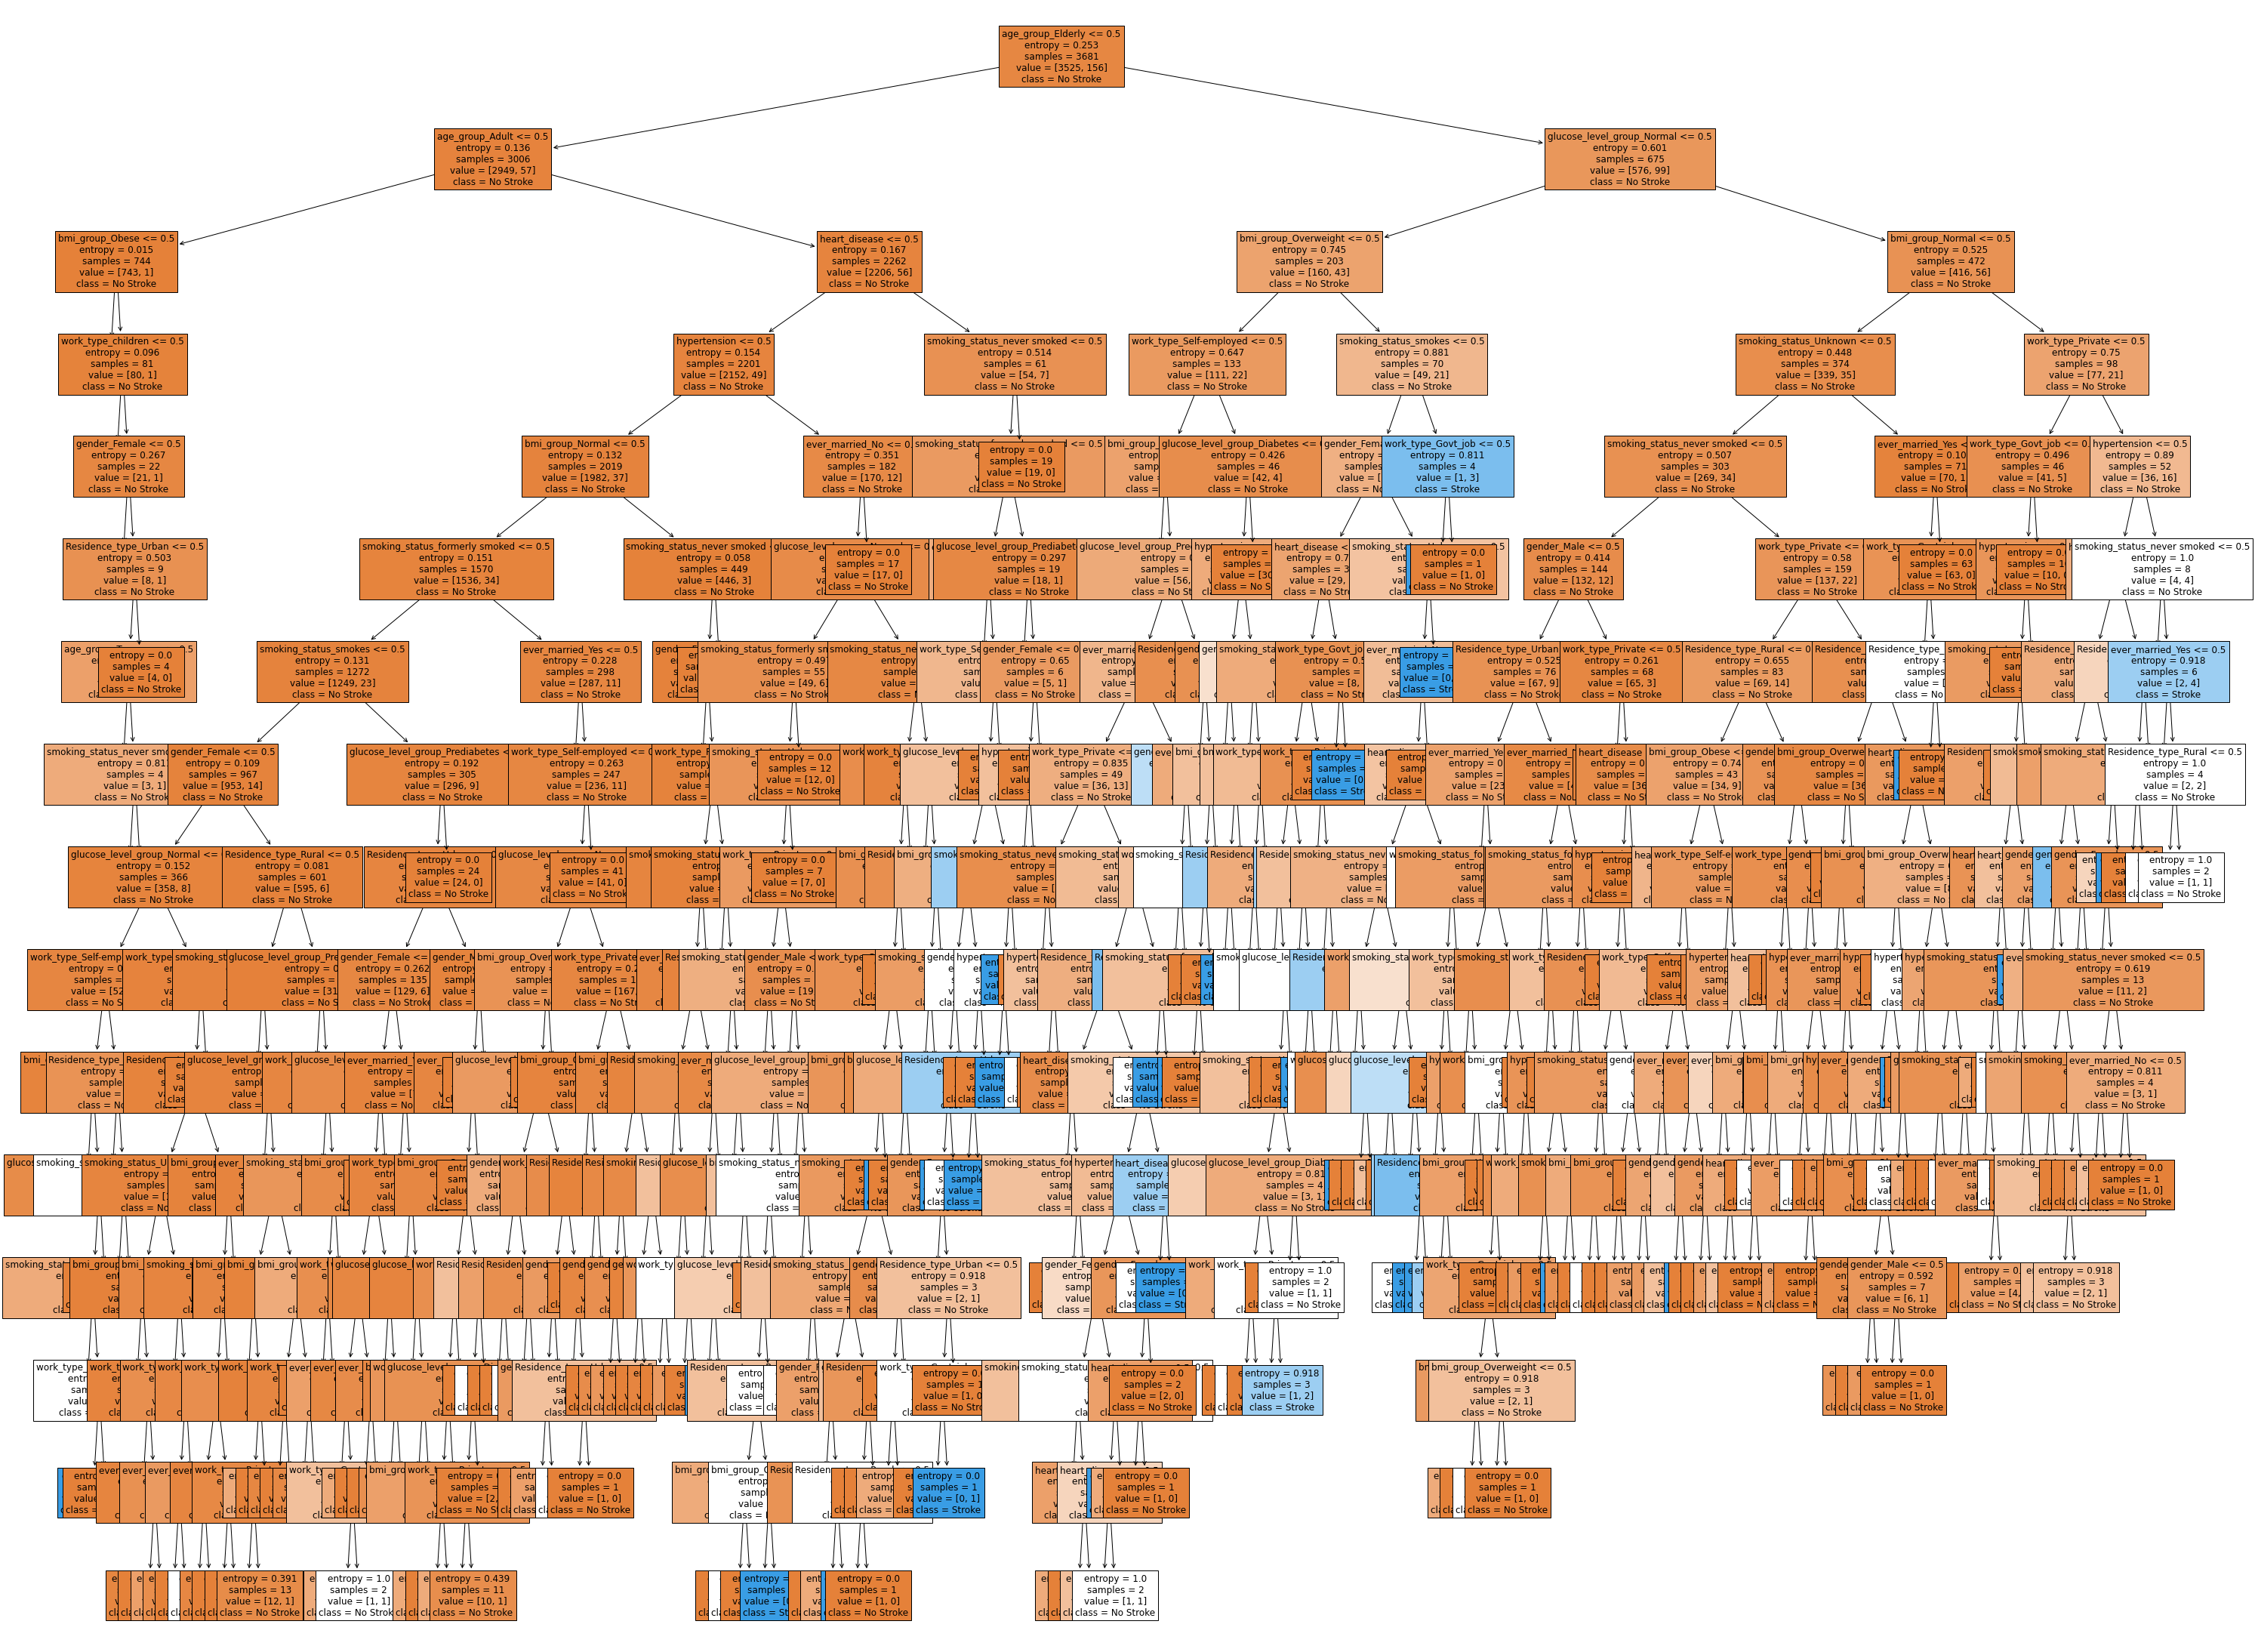

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df_entrada, df_saida)

arvore_decisao = DecisionTreeClassifier(criterion='entropy')
arvore_decisao.fit(X_train, y_train)
arvore_decisao.score(X_test, y_test)

fig, ax = plt.subplots(figsize=(50, 40))
plot_arvore = plot_tree(arvore_decisao, feature_names=df_entrada.columns, impurity=True, filled=True, ax=ax, fontsize=12, class_names=['No Stroke', 'Stroke'])

Parte 2 - Verificar a acurácia do classificador

Nessa célula, é calculada a predição de y_test a partir dos dados de teste X_test, utilizando o modelo de árvore de decisão criado na célula anterior. Em seguida, é calculada a acurácia do modelo, comparando os valores reais de y_test com a predição y_pred (calculada anteriormente), através da função accuracy_score, indicando a proporção de acertos do modelo (aproximadamente 94%).

Além disso, é calculada a hipótese nula, que é uma referência para a acurácia do modelo. A hipótese nula é uma simulação do desempenho do modelo caso ele sempre chutasse a resposta mais frequente do dataset. Isso é importante para avaliar se o modelo está performando melhor do que o simples acaso de escolher sempre a resposta mais comum. A acurácia da hipótese nula é calculada a partir da proporção de amostras na classe da moda, ou seja, a classe com mais ocorrências no dataset. Nesse caso, o valor é aproximadamente 96%, indicando que se o modelo chutasse sempre a resposta mais frequente, ele acertaria numa quantidade alta de vezes, e que existe uma classe mais frequente no dataset (no caso, pessoas que não sofreram AVCs).

In [88]:
y_pred = arvore_decisao.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
print(acuracia *100)


moda = df_saida.mode()[0] 
proporcao_moda = df_saida.value_counts(normalize=True)[moda] 
proporcao_geral = 1 / len(df_saida.unique())  
acuracia_nulo = proporcao_moda  
print(acuracia_nulo * 100)


93.72964169381108
95.74251375025463


Parte 3 - Identificar quais são os fatores que mais provavelmente estão ligados a ter AVCs

Aqui são selecionados os fatores mais importantes através dp atributo feature_importances_. Eles são colocados numa matriz, e em seguida são ordenados em ordem decrescente de importância. Posteriormente, eles são colocados num dataframe e exibido na tela. Esse processo é necessário para visualizarmos quais fatores podem influenciar mais num AVC. 

In [82]:
feature_importances = arvore_decisao.feature_importances_

features = np.array(df_entrada.columns)
importances = np.array(feature_importances).reshape(-1, 1)
feature_importance_matrix = np.concatenate([features.reshape(-1, 1), importances], axis=1)

feature_importance_matrix = feature_importance_matrix[feature_importance_matrix[:,1].argsort()[::-1]]
feature_importance_df = pd.DataFrame(feature_importance_matrix, columns=['Feature', 'Importance'])

print(feature_importance_df)


                            Feature Importance
0                 age_group_Elderly   0.182223
1                     heart_disease    0.05613
2                     gender_Female   0.053745
3                 work_type_Private   0.052199
4              Residence_type_Urban   0.052114
5       smoking_status_never smoked   0.051758
6                      hypertension   0.048438
7            smoking_status_Unknown   0.048019
8                  ever_married_Yes   0.047014
9           work_type_Self-employed   0.046742
10   smoking_status_formerly smoked    0.04327
11                      gender_Male    0.04236
12                  bmi_group_Obese   0.038014
13                 bmi_group_Normal   0.036614
14             Residence_type_Rural   0.036016
15            smoking_status_smokes   0.031198
16             bmi_group_Overweight   0.030554
17               work_type_Govt_job   0.028121
18       glucose_level_group_Normal   0.025306
19     glucose_level_group_Diabetes   0.016866
20  glucose_l